## Look at "Value" from the Value Model

Hoping to see: within a block, "value" of rule increases as trials progress, with jumps in value occuring after to correct feedbacks

### Setup

In [1]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle

from models.value_models import ValueReLUModel, ValueLinearModel, ValueExpModel, ValueNormedExpModel
from models.model_wrapper import ModelWrapper

from models.trainer import Trainer

import torch

matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

In [2]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

# some df magic to get an idx column
reindexed = valid_beh.reset_index()
valid_beh["TrialIdx"] = reindexed.index

/tmp/ipykernel_670251/1067579719.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_beh["TrialIdx"] = reindexed.index


In [3]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))

### Train Model with all the trial data
- Grab all trials to train (fit) model
- Training on time bin 700ms before feedback event
- Model: fully connected layer from neurons to 12 values, 12 values go through a ReLU operation (to avoid negative values)
- 70% accuracy for choice decoding


0.7192681532304174


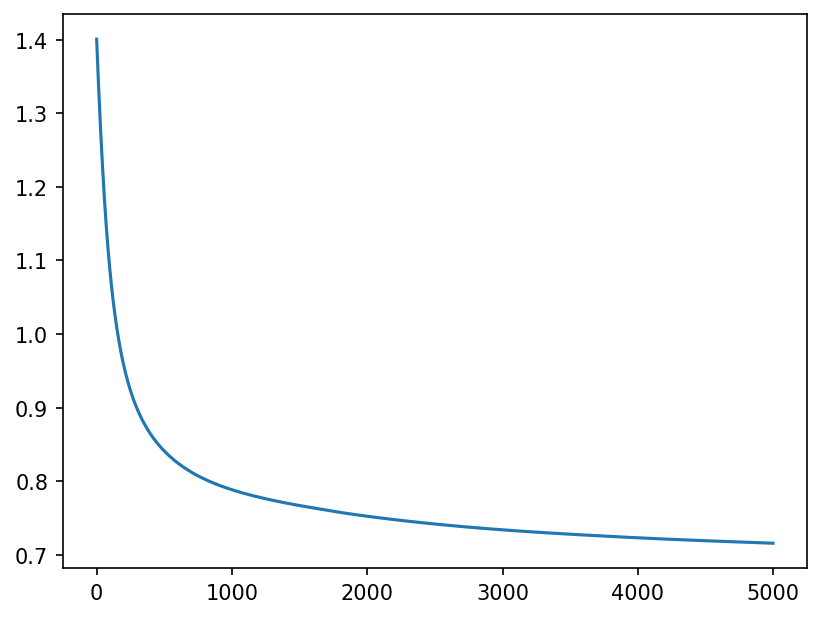

In [4]:
pre_interval = 1300
post_interval = 1500
device = "cuda" if torch.cuda.is_available() else "cpu"


num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12}
trainer = Trainer(learning_rate=0.1, max_iter=5000)
model = ValueNormedExpModel(**init_params)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
# just look at one time bin
# look at 0.6 because that should be where decodabilty is highest
inputs = inputs[np.isclose(inputs["TimeBins"], 0.6)]
# inputs = inputs[np.isclose(inputs["TimeBins"], 1.8)]

labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

x_train = classifier_utils.transform_to_input_data(inputs)
cards_train = classifier_utils.transform_cards_or_none(shuffled_card_idxs)
y_train = classifier_utils.transform_to_label_data(labels)

possible_labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
labels_to_idx = {label: idx for idx, label in enumerate(possible_labels)}
y_train_idxs = np.array([labels_to_idx[label] for label in y_train.tolist()]).astype(int)

losses = trainer.train(model, x_train, y_train_idxs, cards_train)

x = torch.Tensor(x_train).to(device)
cards = torch.Tensor(cards_train).to(torch.long).to(device)

probs = model(x, cards)
label_idxs = np.argmax(probs.detach().cpu().numpy(), axis=1)
train_acc = np.sum(label_idxs == y_train_idxs) / len(y_train_idxs)

print(train_acc)

fig, ax = plt.subplots()
ax.plot(losses)

### Grab all values from decoder across all trials

In [5]:
# choose block number as 1
# rule as CYAN
# index as 4

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.squeeze().detach().cpu().numpy()
    return hook

model.exp.register_forward_hook(get_activation("linear"))

trial_numbers = valid_beh.TrialNumber.unique()

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
# just look at one time bin
# look at 0.6 because that should be where decodabilty is highest
inputs = inputs[np.isclose(inputs["TimeBins"], 0.6)]
# inputs = inputs[np.isclose(inputs["TimeBins"], 1.8)]
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

x = classifier_utils.transform_to_input_data(inputs)
cards = classifier_utils.transform_cards_or_none(shuffled_card_idxs)

x = torch.Tensor(x).to(device)
cards = torch.Tensor(cards).to(torch.long).to(device)
res = model(x, cards)

feature_values = activation["linear"].T

sums = np.sum(feature_values, axis=0)
relative = feature_values / sums
print(relative.shape)
print(relative[:, 0])


(12, 1749)
[6.7458232e-04 6.8372383e-06 1.4008577e-04 1.0671355e-03 1.7980588e-05
 6.9551095e-02 5.2323259e-02 1.0603037e-04 2.4036050e-02 3.4696291e-06
 8.5204089e-01 3.2590204e-05]


### Look at some blocks

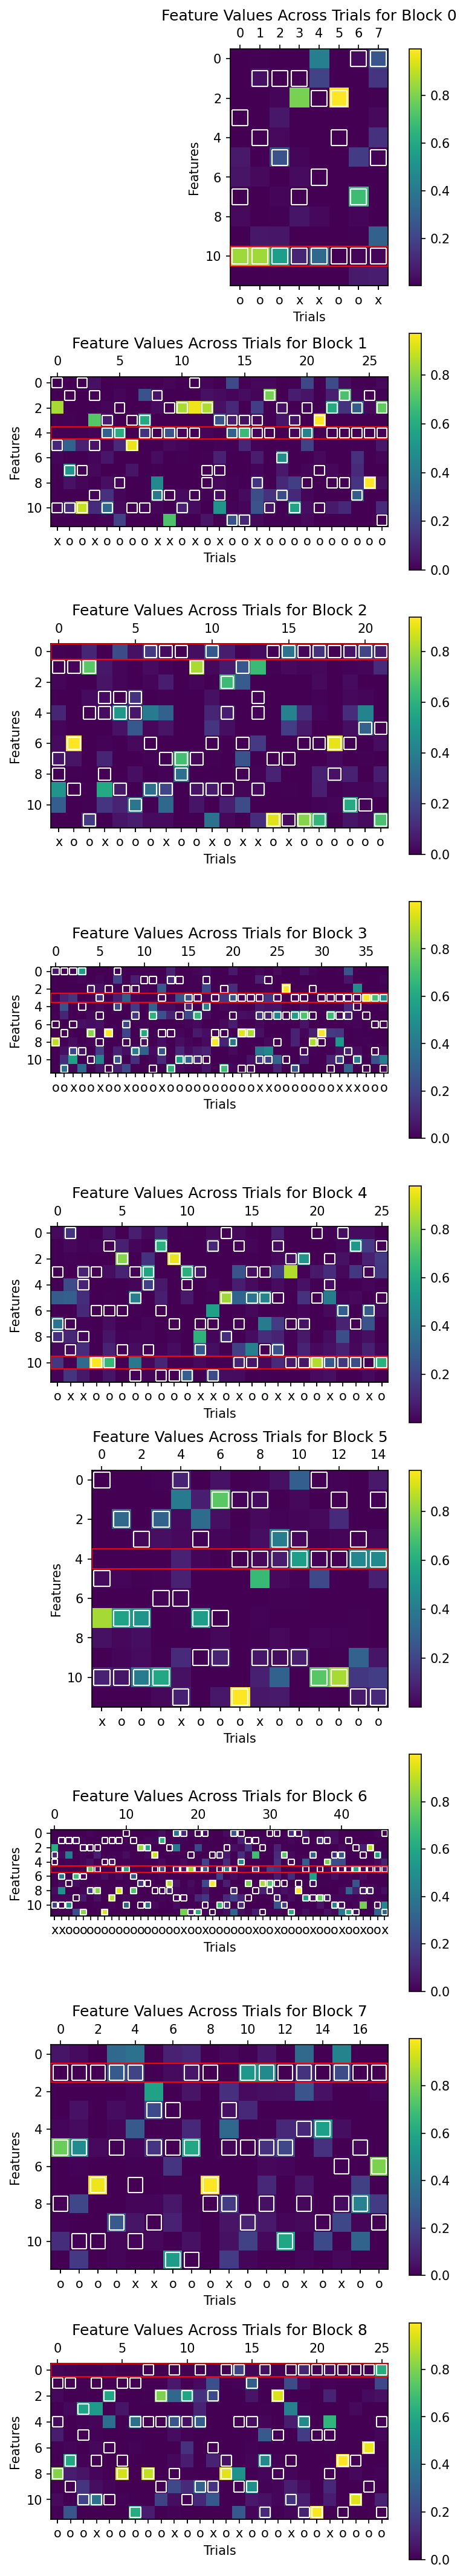

In [6]:
corrects = label_idxs == y_train_idxs
correct_labels = np.array(["o" if correct else "x" for correct in corrects])


def draw_square(x, y, ax):
    left = x - 0.4
    right = x + 0.4
    top = y - 0.4
    bottom = y + 0.4
    hor = ax.hlines(y=[top, bottom], xmin=left, xmax=right, color='white', linewidths=1)
    vert = ax.vlines(x=[left, right], ymin=top, ymax=bottom, color='white', linewidths=1)

def draw_selected_features_for_block(trial_numbers, shuffled_card_idxs, ax):
    for trial_idx, trial_number in enumerate(np.sort(trial_numbers)):
        row = shuffled_card_idxs[shuffled_card_idxs.TrialNumber == trial_number]
        chosen = int(row.ItemChosen)
        for dim in ["Color", "Shape", "Pattern"]:
            feature_idx = classifier_utils.FEATURES.index(row[f"Item{chosen}{dim}"].iloc[0])
            draw_square(trial_idx, feature_idx, ax)

def draw_rule_for_block(rule_idx, x_max, ax):
    left = 0 - 0.5
    right = x_max + 0.5
    top = rule_idx - 0.5
    bottom = rule_idx + 0.5
    hor = ax.hlines(y=[top, bottom], color='red', xmin=left, xmax=right, linewidths=1, zorder=4)
    vert = ax.vlines(x=[left, right], ymin=top, ymax=bottom, color='red', linewidths=1, zorder=4)


blocks = [0, 1, 2, 3, 4, 5, 6, 7, 8]

fig, axs = plt.subplots(len(blocks), 1, figsize=(6, len(blocks) * 4))


for i, block_number in enumerate(blocks):
    ax = axs[i]
    trial_idxs = valid_beh[valid_beh.BlockNumber == block_number].TrialIdx
    trial_numbers = valid_beh[valid_beh.BlockNumber == block_number].TrialNumber
    rule_idx = classifier_utils.FEATURES.index(valid_beh[valid_beh.BlockNumber == block_number].CurrentRule.unique()[0])
    correct_labels_block = correct_labels[trial_idxs]
    block_values = relative[:, trial_idxs]

    colors = ax.matshow(block_values)

    draw_rule_for_block(rule_idx, len(trial_numbers) - 1, ax)
    draw_selected_features_for_block(trial_numbers, shuffled_card_idxs, ax)

    bottom_x_axis = ax.secondary_xaxis('bottom')
    bottom_x_axis.set_xlabel("Trials")
    bottom_x_axis.set_xticks(np.arange(len(correct_labels_block)))
    bottom_x_axis.set_xticklabels(correct_labels_block)


    # draw_selected_features_for_block([8], shuffled_card_idxs, ax)

    fig.colorbar(colors, ax=ax)

    ax.set_ylabel("Features")
    ax.set_title(f"Feature Values Across Trials for Block {block_number}")


### Check performance of Exponential/Log model


Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


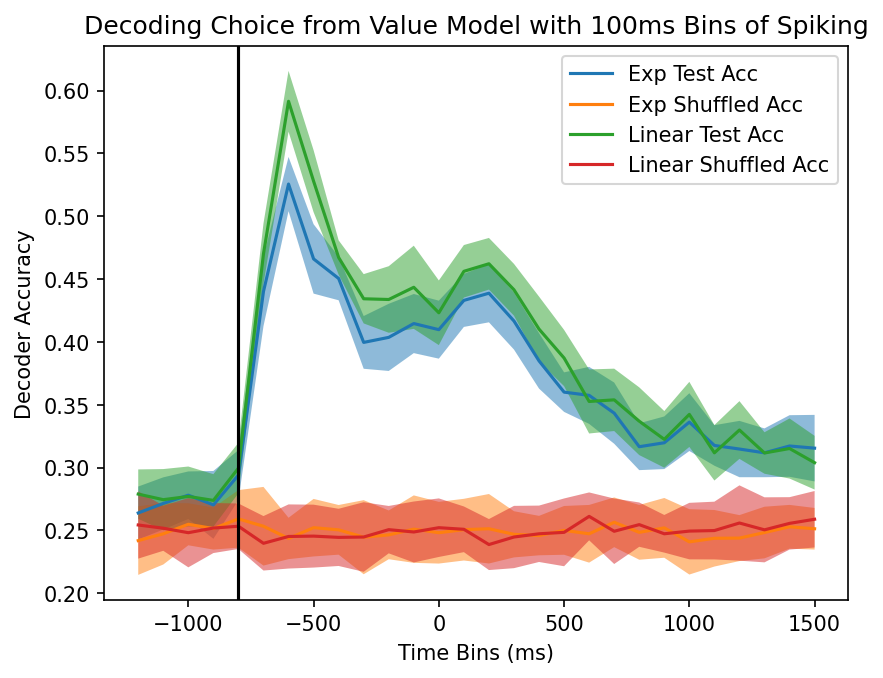

In [5]:
pre_interval = 1300
post_interval = 1500

num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12}
trainer = Trainer(learning_rate=0.1, max_iter=2000)
wrapped = ModelWrapper(ValueExpModel, init_params, trainer, labels)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

_, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=shuffled_card_idxs
)

linear_test_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/value_model_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
linear_shuffled_accs_by_bin = np.load(fs.open(f"l2l.pqz317.scratch/value_model_shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    pre_interval, post_interval, 100,
    ax,
    label="Exp Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Exp Shuffled Acc",
    right_align=True
)

visualization_utils.visualize_accuracy_across_time_bins(
    linear_test_accs_by_bin,
    pre_interval, post_interval, 100,
    ax,
    label="Linear Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    linear_shuffled_accs_by_bin,
    pre_interval, post_interval, 100,
    ax,
    label="Linear Shuffled Acc",
    right_align=True
)

ax.axvline(-800, color='k')
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Choice from Value Model with 100ms Bins of Spiking")
ax.legend()

### Check Max Decoder

0.6523727844482562
(12, 1749)
[2.8396803e-03 7.2183648e-06 1.7211873e-04 1.4402331e-01 5.8790687e-03
 3.9493851e-02 1.2030337e-02 1.5893934e-04 2.4241655e-01 8.5164847e-06
 5.5146158e-01 1.5088561e-03]


/tmp/ipykernel_547090/361020054.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_beh["TrialIdx"] = reindexed.index


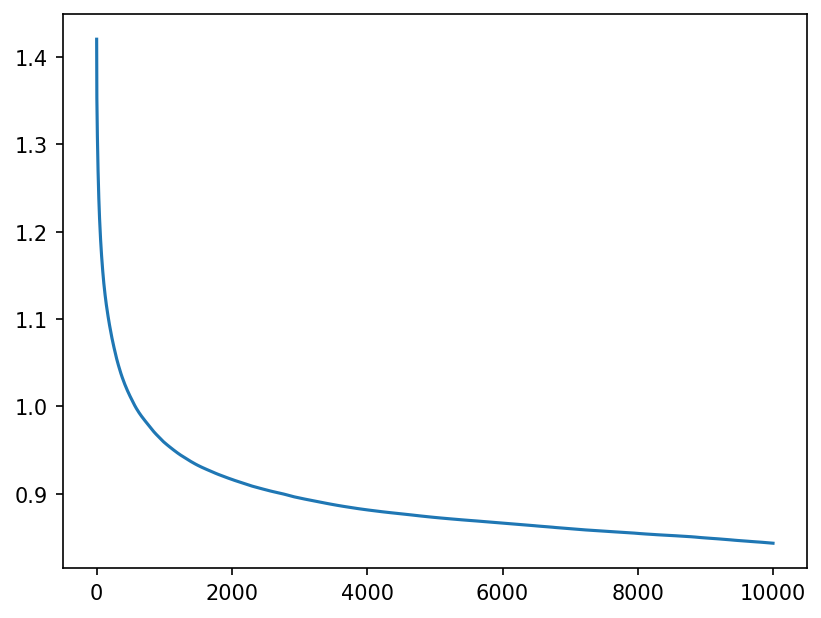

In [9]:
pre_interval = 1300
post_interval = 1500
device = "cuda" if torch.cuda.is_available() else "cpu"


num_neurons = len(firing_rates.UnitID.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_neurons, "n_values": 12, "agg_func": torch.max}
trainer = Trainer(learning_rate=0.1, max_iter=10000)
model = ValueExpModel(**init_params)

mode = "SpikeCounts"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
# just look at one time bin
# look at 0.6 because that should be where decodabilty is highest
inputs = inputs[np.isclose(inputs["TimeBins"], 0.6)]
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

x_train = classifier_utils.transform_to_input_data(inputs)
cards_train = classifier_utils.transform_cards_or_none(shuffled_card_idxs)
y_train = classifier_utils.transform_to_label_data(labels)

possible_labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
labels_to_idx = {label: idx for idx, label in enumerate(possible_labels)}
y_train_idxs = np.array([labels_to_idx[label] for label in y_train.tolist()]).astype(int)

losses = trainer.train(model, x_train, y_train_idxs, cards_train)

x = torch.Tensor(x_train).to(device)
cards = torch.Tensor(cards_train).to(torch.long).to(device)

probs = model(x, cards)
label_idxs = np.argmax(probs.detach().cpu().numpy(), axis=1)
train_acc = np.sum(label_idxs == y_train_idxs) / len(y_train_idxs)

print(train_acc)

fig, ax = plt.subplots()
ax.plot(losses)

# choose block number as 1
# rule as CYAN
# index as 4

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.squeeze().detach().cpu().numpy()
    return hook

model.exp.register_forward_hook(get_activation("linear"))

trial_numbers = valid_beh.TrialNumber.unique()

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
# just look at one time bin
# look at 0.6 because that should be where decodabilty is highest
inputs = inputs[np.isclose(inputs["TimeBins"], 0.6)]
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

x = classifier_utils.transform_to_input_data(inputs)
cards = classifier_utils.transform_cards_or_none(shuffled_card_idxs)

x = torch.Tensor(x).to(device)
cards = torch.Tensor(cards).to(torch.long).to(device)
res = model(x, cards)

feature_values = activation["linear"].T

sums = np.sum(feature_values, axis=0)
relative = feature_values / sums
print(relative.shape)
print(relative[:, 0])

reindexed = valid_beh.reset_index()
valid_beh["TrialIdx"] = reindexed.index

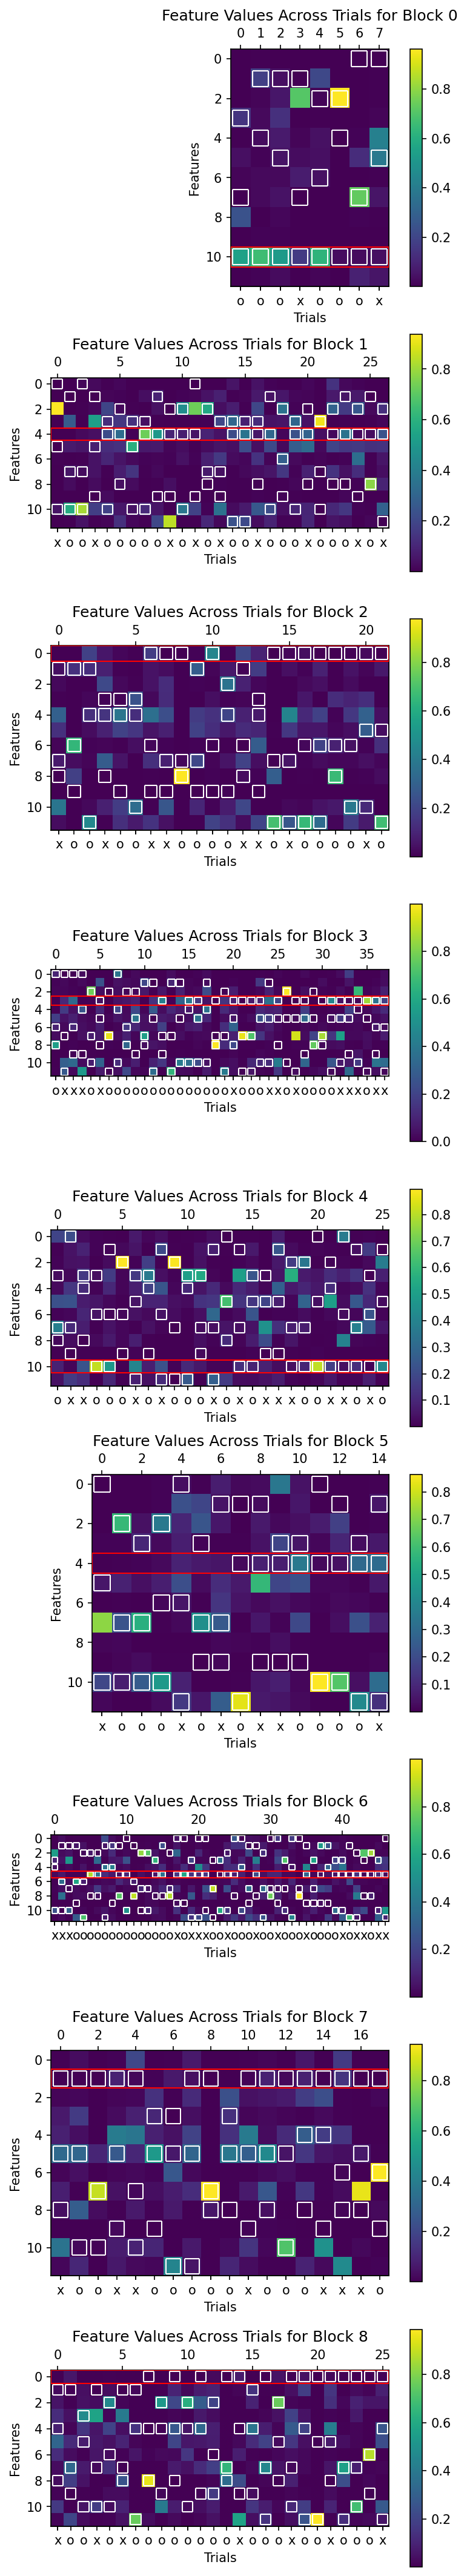

In [10]:
corrects = label_idxs == y_train_idxs
correct_labels = np.array(["o" if correct else "x" for correct in corrects])


def draw_square(x, y, ax):
    left = x - 0.4
    right = x + 0.4
    top = y - 0.4
    bottom = y + 0.4
    hor = ax.hlines(y=[top, bottom], xmin=left, xmax=right, color='white', linewidths=1)
    vert = ax.vlines(x=[left, right], ymin=top, ymax=bottom, color='white', linewidths=1)

def draw_selected_features_for_block(trial_numbers, shuffled_card_idxs, ax):
    for trial_idx, trial_number in enumerate(np.sort(trial_numbers)):
        row = shuffled_card_idxs[shuffled_card_idxs.TrialNumber == trial_number]
        chosen = int(row.ItemChosen)
        for dim in ["Color", "Shape", "Pattern"]:
            feature_idx = classifier_utils.FEATURES.index(row[f"Item{chosen}{dim}"].iloc[0])
            draw_square(trial_idx, feature_idx, ax)

def draw_rule_for_block(rule_idx, x_max, ax):
    left = 0 - 0.5
    right = x_max + 0.5
    top = rule_idx - 0.5
    bottom = rule_idx + 0.5
    hor = ax.hlines(y=[top, bottom], color='red', xmin=left, xmax=right, linewidths=1, zorder=4)
    vert = ax.vlines(x=[left, right], ymin=top, ymax=bottom, color='red', linewidths=1, zorder=4)


blocks = [0, 1, 2, 3, 4, 5, 6, 7, 8]

fig, axs = plt.subplots(len(blocks), 1, figsize=(6, len(blocks) * 4))


for i, block_number in enumerate(blocks):
    ax = axs[i]
    trial_idxs = valid_beh[valid_beh.BlockNumber == block_number].TrialIdx
    trial_numbers = valid_beh[valid_beh.BlockNumber == block_number].TrialNumber
    rule_idx = classifier_utils.FEATURES.index(valid_beh[valid_beh.BlockNumber == block_number].CurrentRule.unique()[0])
    correct_labels_block = correct_labels[trial_idxs]
    block_values = relative[:, trial_idxs]

    colors = ax.matshow(block_values)

    draw_rule_for_block(rule_idx, len(trial_numbers) - 1, ax)
    draw_selected_features_for_block(trial_numbers, shuffled_card_idxs, ax)

    bottom_x_axis = ax.secondary_xaxis('bottom')
    bottom_x_axis.set_xlabel("Trials")
    bottom_x_axis.set_xticks(np.arange(len(correct_labels_block)))
    bottom_x_axis.set_xticklabels(correct_labels_block)


    # draw_selected_features_for_block([8], shuffled_card_idxs, ax)

    fig.colorbar(colors, ax=ax)

    ax.set_ylabel("Features")
    ax.set_title(f"Feature Values Across Trials for Block {block_number}")


### Check Value Distributions
Of the selected features during correct trials (rule included), plot distribution of rule value vs other feature values
Is there a different when trials are split between figured and not-figured?

In [37]:


def split_vals_by_rule_non_rule(trials, feature_values):
    non_rule_values = []
    rule_values = []

    for _, row in trials.iterrows():
        chosen = int(row.ItemChosen)
        rule_idx = classifier_utils.FEATURES.index(row.CurrentRule)

        for dim in ["Color", "Shape", "Pattern"]:
            feature_idx = classifier_utils.FEATURES.index(row[f"Item{chosen}{dim}"])
            value = feature_values[feature_idx, row.TrialIdx]
            if feature_idx != rule_idx:
                non_rule_values.append(value)
            else:
                rule_values.append(value)
    return rule_values, non_rule_values

correct = valid_beh[valid_beh.Response == "Correct"]
rule_values, non_rule_values = split_vals_by_rule_non_rule(correct, relative)
print(len(non_rule_values))
print(len(rule_values))


1968
984


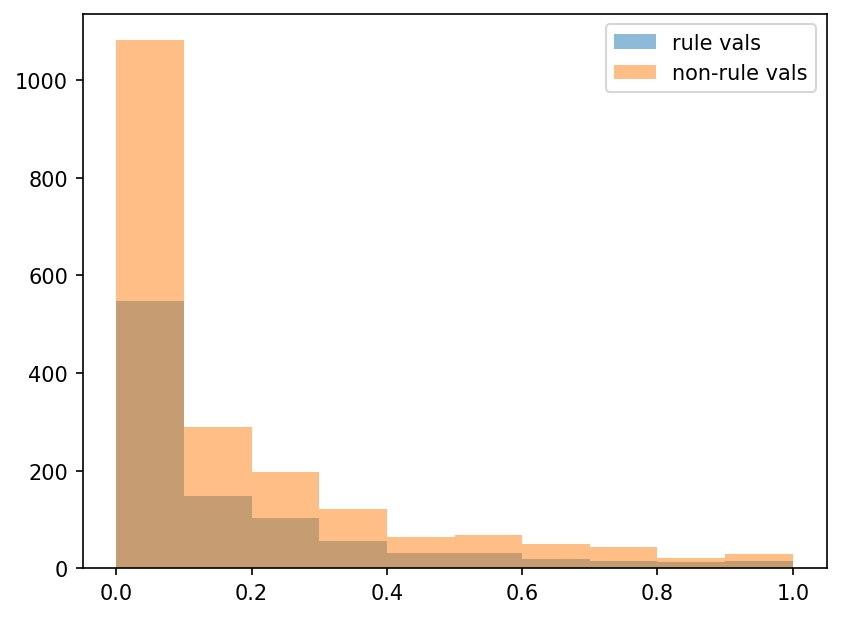

In [46]:
fig, ax = plt.subplots()

bins = np.arange(0, 1.1, 0.05)

ax.hist(rule_values, bins, alpha=0.5, label="rule vals")
ax.hist(non_rule_values, bins, alpha=0.5, label="non-rule vals")
ax.legend()


447
537
447
537


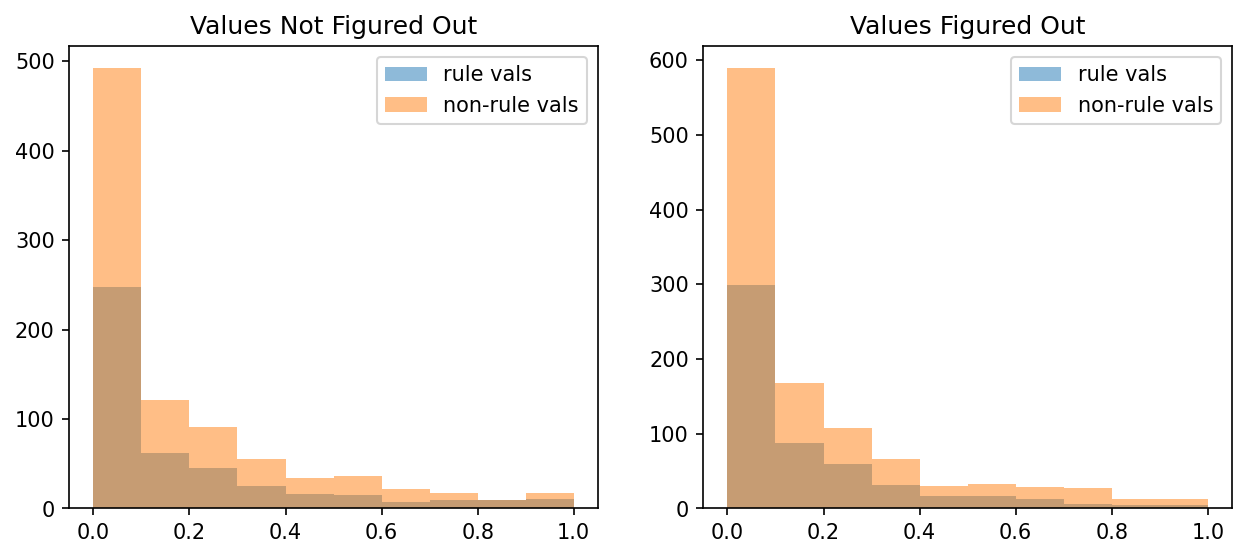

In [47]:
figured_out = behavioral_utils.get_figured_out_trials(valid_beh)
not_figured_out = behavioral_utils.get_not_figured_out_trials(valid_beh)

correct_figured_out = figured_out[figured_out.Response == "Correct"]
correct_not_figured_out = not_figured_out[not_figured_out.Response == "Correct"]

print(len(correct_not_figured_out))
print(len(correct_figured_out))

not_figured_rule_values, not_figured_non_rule_values = split_vals_by_rule_non_rule(correct_not_figured_out, relative)
figured_rule_values, figured_non_rule_values = split_vals_by_rule_non_rule(correct_figured_out, relative)

print(len(not_figured_rule_values))
print(len(figured_rule_values))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(not_figured_rule_values, bins, alpha=0.5, label="rule vals")
axs[0].hist(not_figured_non_rule_values, bins, alpha=0.5, label="non-rule vals")
axs[0].set_title("Values Not Figured Out")
axs[0].legend()

axs[1].hist(figured_rule_values, bins, alpha=0.5, label="rule vals")
axs[1].hist(figured_non_rule_values, bins, alpha=0.5, label="non-rule vals")
axs[1].set_title("Values Figured Out")
axs[1].legend()
